# 3. Preprocessament de les imatges

### Input: Arxiu .csv amb les rutes i característiques de les mamografies unificades. 

### Output: Arrays de numpy de les imatges i etiquetes corresponents per a l'entrenament, validació i test. Arxius csv corresponents amb els index de les imatges

**En aquest apartat realitzarem el preprocessament de les imatges per tal d'equiparar els diferents datasets i poder traslladar al model les imatges preprocessades. L'objectiu serà classificar les imatges mamogràfiques en tres categories: Normals, Benignes i Malignes**

El procediment seguit és el següent:

- Retallarem els bordes blancs per tal de facilitar la creació de la màscara binària
- En primer lloc crearem una màscara binària per eliminar tot el que no siguin imatges mamogràfiques. Etiquetes, pixels blancs sense utilitat, bordes blancs, etc Segons el tipus de dataset i orígen de la imatge aplicarem un thershold diferent.
- Truncació-normalització. Retallarem els valors negres que donen menys utilitat a la imatge i podrien afectar la normalització i la normalitzarem
- CLAHE: tècnica per millorar el contrast local de la imatge
- Fusionarem la imatge original, la truncació_normalització i la clahe en cada un dels tres canals per donar com a resultat una imatge rgb
- Crearem tres datasets d'entrenament, validació i test amb les rutes a les imatges i barrejarem aleatoriament.
- Crearem tres arrays per cada conjunt (train, test i val) d'imatges i etiquetes preprocessades i els guardarem en format array de numpy per poder enviar a l'entrenament dels models, que realitzarem en una plataforma externa (Kaggle/ Colab)
- Mostrarem resultats finals


## Carreguem les llibreries

In [14]:
from keras.utils import image_dataset_from_directory

from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input, 
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, AveragePooling2D,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Lambda)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from keras.optimizers import (Adam, RMSprop)
from keras import Sequential, Model

import tensorflow as tf

import pywt
from skimage.metrics import peak_signal_noise_ratio
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import random
import cv2


In [15]:
# Importem Tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necessitarem GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

#Keras version is 3.0.5
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.16.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  3.1.1


## 3.1. Experiment 3 classes: Normal - Benigne - Maligne

### En primer lloc carreguem el fitxer amb les rutes i les característiques de les imatges. En aquest cas seleccionarem només els casos que siguin normals o continguin tumors (mass).

In [16]:
df = pd.read_csv('LabelsPaths.csv')

df.info()


df = df[((df['Calcification'] == 0) & (df['Distortion'] == 0) & (df['Asymmetry'] == 0) & (df['Mass'] == 1)) | (df['Label'] == 0)]

df = df[df['Path'] != '0']

df['Label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9688 entries, 0 to 9687
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Database       9688 non-null   object 
 1   Image_name     9688 non-null   object 
 2   View           9688 non-null   object 
 3   Path           9688 non-null   object 
 4   Label          9688 non-null   int64  
 5   ACR            9688 non-null   object 
 6   Mass           9688 non-null   float64
 7   Mass_shape     9688 non-null   object 
 8   Calcification  9688 non-null   float64
 9   Distortion     9688 non-null   float64
 10  Asymmetry      9688 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 832.7+ KB


Label
0    3036
1    1962
2    1759
Name: count, dtype: int64

# Funcions

### Definim les funcions que utilitzarem durant el procés de processament de les imatges

In [17]:
def trim_image(image, margin=30):
    """
    Retalla una imatge en els marges especificats.

    Args:
    - image (array): Imatge d'entrada.
    - margin (int): Mida del marge a retallar de la imatge. El valor per defecte és 20.

    Returns:
    - array: Imatge retallada.
    """
    height, width = image.shape[:2]
    trimmed_image = image[margin:height-margin, margin:width-margin]

    return trimmed_image

    
# https://stackoverflow.com/questions/64850305/opencv-segmentation-of-largest-contour-in-breast-mammograms

def preprocess_image(img_path, threshold_value=30):
    """
    Realitza el pre-processament de la imatge especificada.

    Args:
    - img_path (str): Ruta de la imatge a pre-processar.
    - threshold_value (int): Valor de llindar per a la binarització. El valor per defecte és 30.

    Returns:
    - tuple: Una tupla que conté tres elements:
        * result (array): Imatge pre-processada amb la màscara aplicada.
        * crop (array): Regió retallada de la imatge original.
        * mask (array): Màscara binària que delimita la regió d'interès.
    """
    try:
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"Imatge no trobada: {img_path}")
            return None, None
            
        img2 = trim_image(img)
        
        # convertim a gris
        gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            
        # apliquem threshold i invertim
        thresh1 = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)[1]
        thresh1 = 255 - thresh1
    
        # comptem número de pixels
        count_cols = np.count_nonzero(thresh1, axis=0)
    
        # busquem coordenades amb pixels negres
        first_x = np.where(count_cols>0)[0][0]
        last_x = np.where(count_cols>0)[0][-1]
    
        # comptem número de píxels blancs
        count_rows = np.count_nonzero(thresh1, axis=1)
    
        # obtenim primer i última coordenada y negra.
        first_y = np.where(count_rows>0)[0][0]
        last_y = np.where(count_rows>0)[0][-1]

        # retallem image
        crop = img[first_y:last_y+1, first_x:last_x+1]
    
        # retallem el llindar i invertim
        thresh2 = thresh1[first_y:last_y+1, first_x:last_x+1]
        thresh2 = 255 - thresh2
    
        # busquem els contorns i mantenim el més gran
        contours = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        big_contour = max(contours, key=cv2.contourArea)
    
        # a partir del contorn creem la màscara.
        mask = np.zeros_like(thresh2 , dtype=np.uint8)
        
        cv2.drawContours(mask, [big_contour], 0, 255, -1)
    
        result = crop.copy()
        result[mask==0] = (0,0,0)
    
        return result, crop, mask

    except Exception as e:
        print(f"Error: {e}")
        return None, None


# Normalització: Aquesta funció realitza la truncació i normalització dels píxels d'una imatge dins de la regió d'interès de les mames.

# Truncació: En la primera part, la funció calcula els percentils 50 i 99 dels píxels dins de la màscara. 
# El percentil 50 (Pmin) serveix com a límit inferior, mentre que el percentil 99 (Pmax) és el límit superior. 
# Això implica que els valors dels píxels fora d'aquests límits es tallen (clip) per a mantenir els valors dins d'aquest rang.

# Normalització: A continuació, la funció normalitza els valors dels píxels truncats dins del rang [Pmin, Pmax] per a assegurar que 
# estiguin compresos entre 0 i 1. 

def truncation_normalization(img, mask):
    """
    Normalitza la imatge utilitzant la truncació.

    Args:
    - img (array): Imatge d'entrada.
    - mask (array): Màscara que especifica les regions d'interès de la imatge.

    Returns:
    - array: Imatge normalitzada utilitzant la truncació.
    """
    Pmin = np.percentile(img[mask!=0], 25)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

def truncation_normalization2(gray_img):
    """
    Normalitza la imatge utilitzant la truncació.

    Args:
    - img (array): Imatge d'entrada.

    Returns:
    - array: Imatge normalitzada utilitzant la truncació.
    """
    Pmin = np.percentile(gray_img, 75)
    Pmax = np.percentile(gray_img, 99)
    truncated = np.clip(gray_img, Pmin, Pmax)  
    normalized = (truncated - Pmin) / (Pmax - Pmin)
    return normalized


def pad_into_square(img):
    """
    Realitza un padding de la imatge a un fons negre quadrat.

    Args:
    - img (array): Imatge d'entrada.

    Returns:
    - array:  Imatge amb un quadrat negre.
    """
    height, width = img.shape
    
    max_size = max(height, width)
    
    square_image = np.zeros((max_size, max_size), dtype=np.uint8)

    # Per decidir si una imatge és dreta o esquerra comprovem quin lateral té més pixels negres
    
    num_black_pixels_left = np.sum(img[:, 0] == 0)
    num_black_pixels_right = np.sum(img[:, -1] == 0)
    
    # Compara el nombre total de píxels negres en cada marge
    if num_black_pixels_left >= num_black_pixels_right:
        start_x = max_size - width
    else:
        start_x = 0
    
    start_y = (max_size - height) // 2
    
    square_image[start_y:start_y+height, start_x:start_x+width] = img
    
    return square_image



def clahe(img, clip):
    """
    Millora el contrast de la imatge utilitzant l'algoritme CLAHE (Contrast Limited Adaptive Histogram Equalization).

    Args:
    - img (array): Imatge d'entrada.
    - clip (float): Límit de retall per al contrast. Valors més grans generen més contrast. 

    Returns:
    - array: Imatge millorada amb CLAHE.
    """

    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl



def resize_image(image, size):
    """
    Redimensiona una imatge a les dimensions desitjades.
    
    Arguments:
    image: np.array
        La imatge que es vol redimensionar.
        
    Returns:
    np.array
        La imatge redimensionada.
    """
    resized_image = cv2.resize(image, (size, size))
    return resized_image



# https://core.ac.uk/download/pdf/229655805.pdf
# https://www.researchgate.net/publication/284204752_An_Enhanced_Approach_for_Preprocessing_of_Mammogram_Images_using_Inverse_Daubechies_Wavelet_Transform_and_Non-Linear_Diffusion

def apply_dwt(image):
    """
    Aplica la Transformada Discreta d'Ondaleta (DWT) a una imatge.

    Args:
    - image (array): Imatge d'entrada en format array.

    Returns:
    - array: Imatge reconstruïda després d'aplicar la DWT.
    """

    if len(image.shape) > 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Apliquem la DWT
    coeffs = pywt.dwt2(gray_image, 'db2')

    # Invertim la DWT per obtenir la imatge processada
    reconstructed_image = pywt.idwt2(coeffs, 'db2')

    return reconstructed_image


def apply_filter(image, num = 3):
    """
    Aplica un filtre mitjà de num x num a una imatge per eliminar el soroll.

    Args:
    - image (array): Imatge d'entrada en format array.
    - num (int): mida del filtre

    Returns:
    - array: Imatge reconstruïda després d'aplicar el filtre.
    """

    if len(image.shape) > 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
        
    kernel = np.ones((num, num), np.float32) / 9 

    filtered_image = cv2.filter2D(gray_image, -1, kernel)

    return filtered_image


def synthesized_images(image_path, image_size = 299, threshold_value = 10):
    """
    Síntesi d'imatges mitjançant la combinació de truncation_normalization + clahe + img.
    
    Args:
    - image_path (str): Ruta de la imatge d'entrada.
    - image_size (int): Mida de la imatge resultant. Per defecte, 299 píxels.
    - threshold_value (int): Valor de llindar per a la binarització de la imatge. Per defecte, 10.

    Returns:
    - array: Imatge sintetitzada.
    """

    result, crop, mask = preprocess_image(image_path, threshold_value)
    
    result2 = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    padded = pad_into_square(result2)

    denoised_img = apply_filter(padded)
    
    norm = truncation_normalization2(denoised_img)

    norm2 = np.array(norm*255, dtype=np.uint8)

    cl2 = clahe(denoised_img, 3.0)

    rgb_image = np.stack((cl2, norm2, padded), axis=-1)

    rgb_resized = resize_image(rgb_image, image_size)

    return rgb_resized

        
        
def preprocess(df, target_size):
    """
    Preprocessa i redimensiona les imatges d'acord amb les especificacions
    del dataframe i la mida de destí.
    
    Arguments:
    df: pandas.DataFrame
        El dataframe que conté la informació de les imatges.
    target_size: tuple
        La mida de destí de les imatges (alcada, amplada).
        
    Returns:
    list
        Un array de numpy que conté les imatges preprocessades i redimensionades.
    """
    
    labels = []
    images = []
    
    for index, row in df.iterrows():
        image_path = row['Path']
        if row['Database'] == 'DDSM':
            threshold_value = 30
        elif row['Database'] == 'MIAS':
            threshold_value = 20
        else:
            threshold_value = 5
            
        synt = synthesized_images(image_path, image_size = target_size, threshold_value = threshold_value)
        
        label = row['Label']
        
        images.append(synt) 
        
        labels.append(label)

    
    return np.array(images), np.array(labels)






## Funcions de visualització

In [18]:
def plot_histogram(image):
    """
    Representa un histograma de la imatge especificada.

    Args:
    - image (array): Imatge de la qual es vol calcular l'histograma.

    Returns:
    - No retorna cap valor, només mostra l'histograma de la imatge.
    """

    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
    else:
        gray_image = image

    # No mostrem els negres per una millor visualització
    histogram = cv2.calcHist([gray_image], [0], None, [256], [1, 256])

    plt.plot(histogram, color='black')
    plt.xlim([0, 256])
    plt.axis('off')



def visualize_images(df, dataset, num_samples=15, threshold_value = 15, seed=None):
    """
    Visualitza una mostra aleatòria d'imatges del dataset especificat mostrant les etapes de prepocessament.

    Args:
    - df (DataFrame): DataFrame que conté les dades del dataset.
    - dataset (str): Nom del dataset dins del DataFrame.
    - num_samples (int): Nombre de mostres a visualitzar. Per defecte, 15.
    - seed (int): Llavor per a la generació de nombres aleatoris. Per defecte, None.

    Returns:
    - No retorna cap valor, només mostra les imatges i la informació associada.
    """

    if seed is not None:
        np.random.seed(seed)

    sampled_images = df[df['Database'] == dataset].sample(n=num_samples)

    for index, row in sampled_images.iterrows():
        image_path = row['Path']

        img = cv2.imread(image_path)
        result, crop, mask = preprocess_image(image_path, threshold_value=35)

        result2 = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        
        padded = pad_into_square(result2)
        
        filt_img = apply_filter(padded)
        
        norm = truncation_normalization2(filt_img)
        
        norm2 = np.array(norm*255, dtype=np.uint8)
        
        clahe2 = clahe(filt_img, clip=3.0)
        
        synt = synthesized_images(image_path, threshold_value=threshold_value)

        plt.figure(figsize=(12, 6))

        plt.subplot(2, 5, 1)
        plt.imshow(result2, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(2, 5, 2)
        plt.imshow(filt_img, cmap='gray')
        plt.title('Denoised image')
        plt.axis('off')
        
        plt.subplot(2, 5, 3)
        plt.imshow(norm2, cmap='gray')
        plt.title('Norm Image')
        plt.axis('off')

        plt.subplot(2, 5, 4)
        plt.imshow(clahe2, cmap='gray')
        plt.title('Enhanced Image')
        plt.axis('off')

        plt.subplot(2, 5, 5)
        plt.imshow(synt)
        plt.title('Merged Image')
        plt.axis('off')

        plt.subplot(2, 5, 6)
        plot_histogram(result2)

        plt.subplot(2, 5, 7)
        plot_histogram(filt_img)
        
        plt.subplot(2, 5, 8)
        plot_histogram(norm2)
        
        plt.subplot(2, 5, 9)
        plot_histogram(clahe2)
        
        plt.subplot(2, 5, 10)
        plot_histogram(synt)

        plt.show()

        print(f"Path: {row['Path']}, Label: {row['Label']}, Type: {row['Mass_shape']}")



def plot_examples_post(test_images, test_labels, num_ex):
    """
    Mostra una selecció d'imatges amb les seves etiquetes corresponents per comprovar el preprocessat.

    Args:
    - test_images (array): Array que conté les imatges a visualitzar.
    - test_labels (array): Array que conté les etiquetes corresponents a les imatges.
    - num_ex (int): Nombre d'imatges a visualitzar.

    Returns:
    - No retorna cap valor, només mostra les imatges i les seves etiquetes associades.
    """

    num_rows = (num_ex + 7) // 8  
    fig, axes = plt.subplots(num_rows, 8, figsize=(15, num_rows * 3))

    for i in range(num_ex):
        row = i // 8  
        col = i % 8  
        axes[row, col].imshow(test_images[i]) 
        axes[row, col].set_title(f"Sample {i+1}\nLabel: {test_labels[i]}")  
        axes[row, col].axis('off')  

    for i in range(num_ex, num_rows * 8):
        row = i // 8
        col = i % 8
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


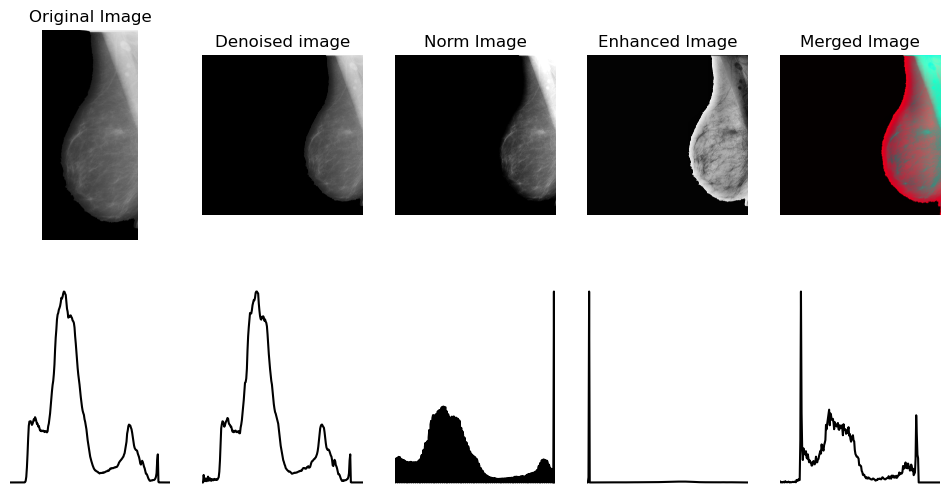

Path: DATABASE - DDSM/Normal/0335/A_0335_1.LEFT_MLO.jpg, Label: 0, Type: 0


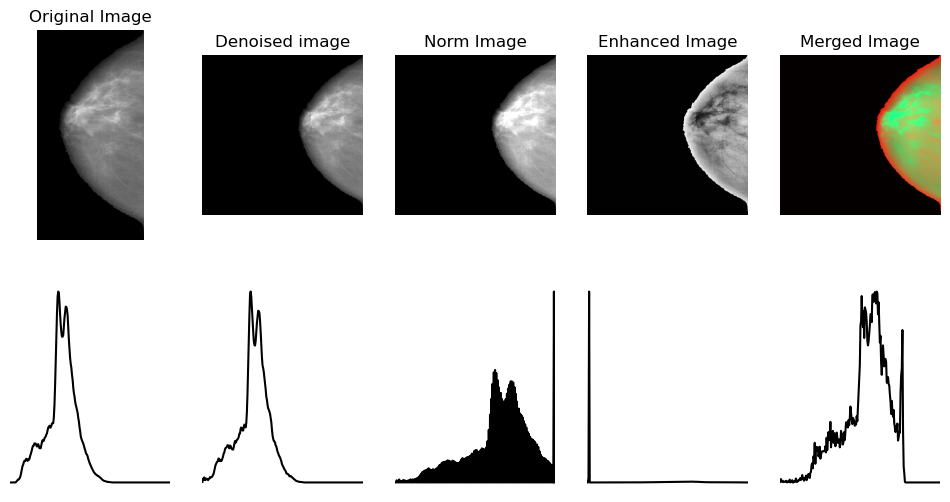

Path: DATABASE - DDSM/Benign/4081/D_4081_1.RIGHT_CC.jpg, Label: 1, Type: Obscured


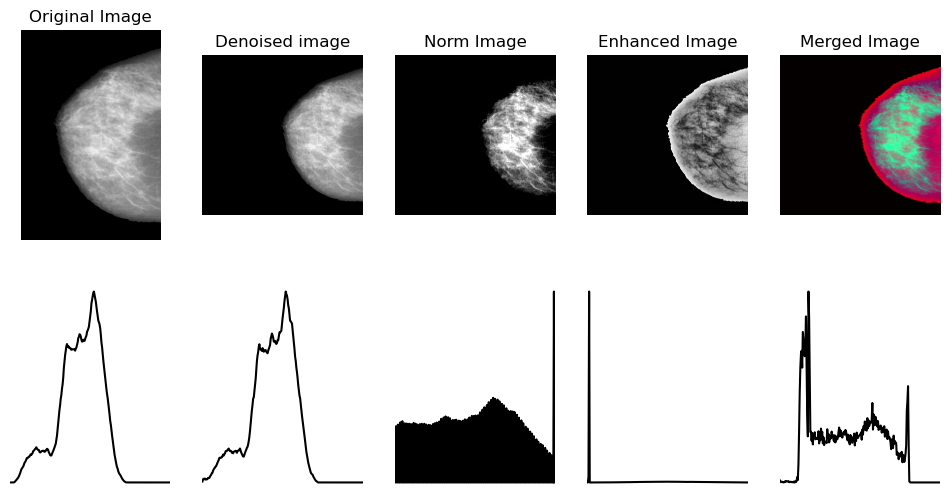

Path: DATABASE - DDSM/Normal/4573/D_4573_1.RIGHT_CC.jpg, Label: 0, Type: 0


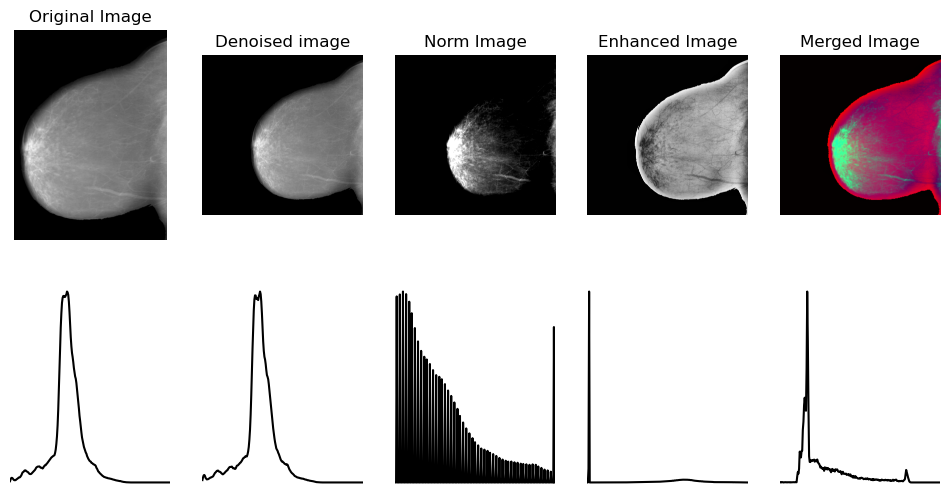

Path: DATABASE - DDSM/Normal/1969/A_1969_1.LEFT_CC.jpg, Label: 0, Type: 0


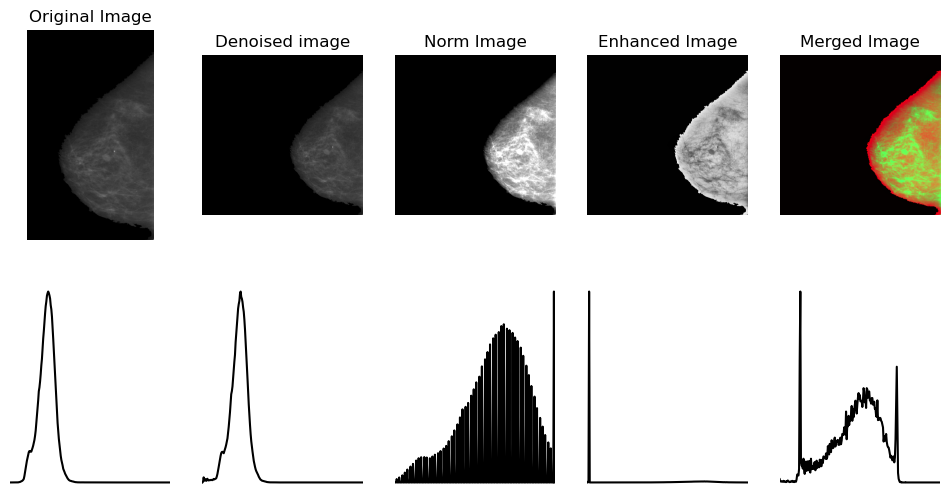

Path: DATABASE - DDSM/Cancer/1676/A_1676_1.LEFT_CC.jpg, Label: 2, Type: Obscured


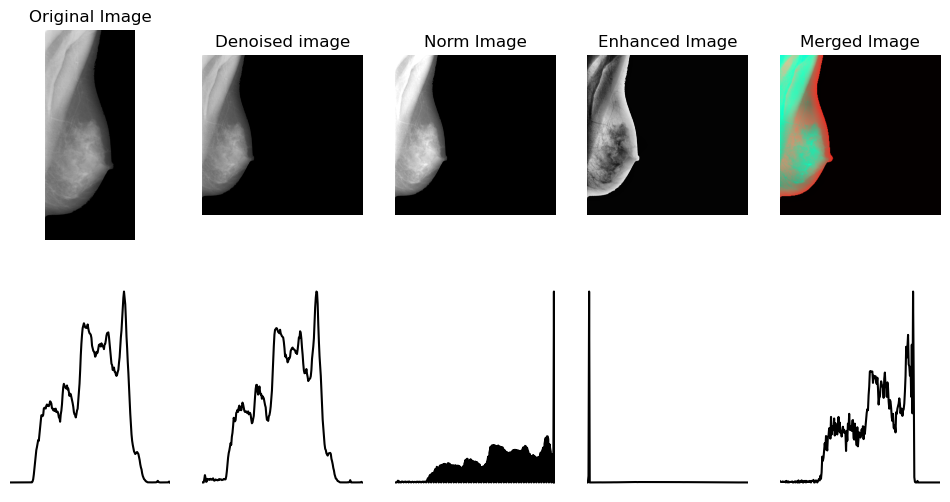

Path: DATABASE - DDSM/Normal/0056/A_0056_1.RIGHT_MLO.jpg, Label: 0, Type: 0


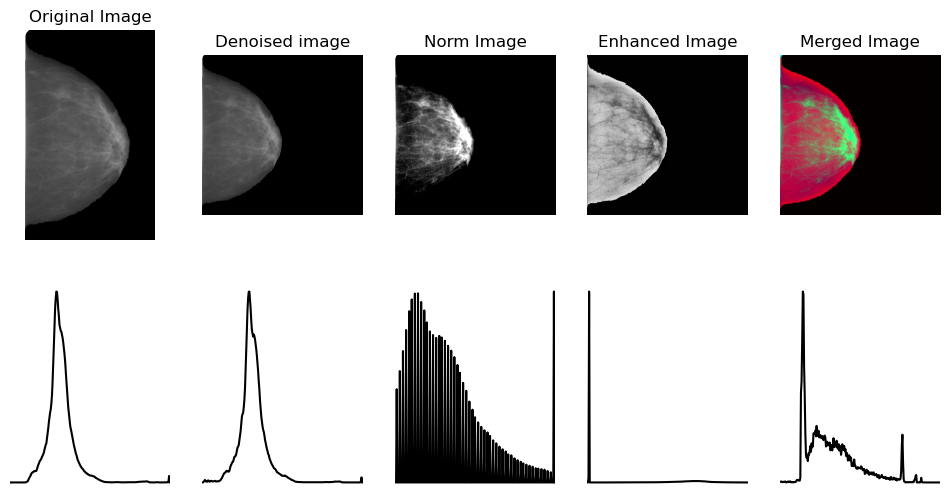

Path: DATABASE - DDSM/Normal/0613/A_0613_1.RIGHT_CC.jpg, Label: 0, Type: 0


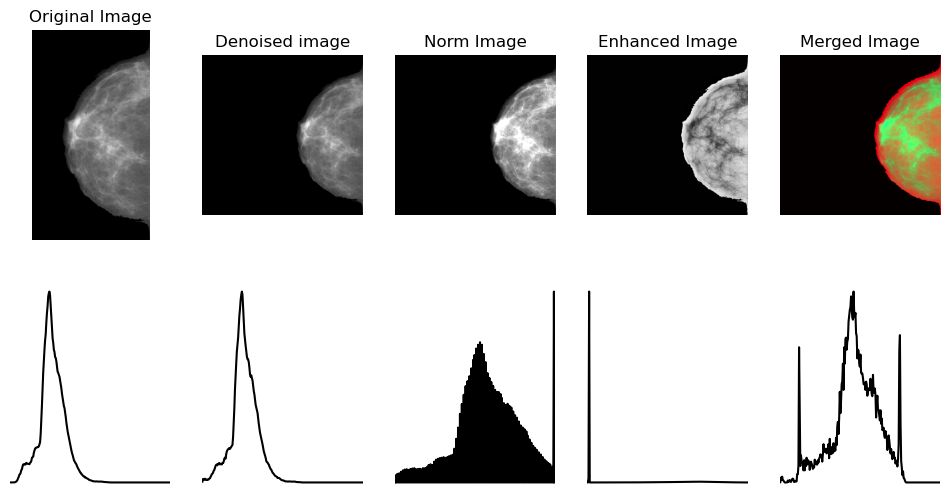

Path: DATABASE - DDSM/Benign/4071/D_4071_1.RIGHT_CC.jpg, Label: 1, Type: Obscured


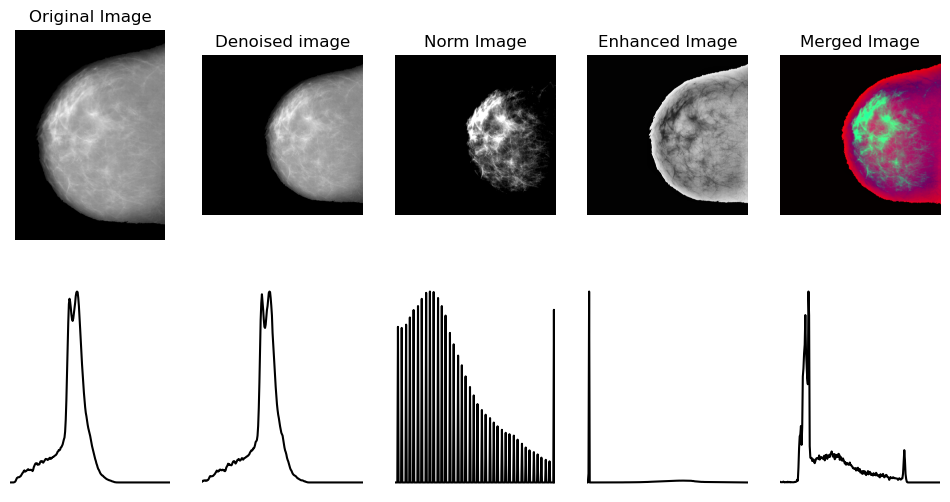

Path: DATABASE - DDSM/Normal/4570/D_4570_1.LEFT_CC.jpg, Label: 0, Type: 0


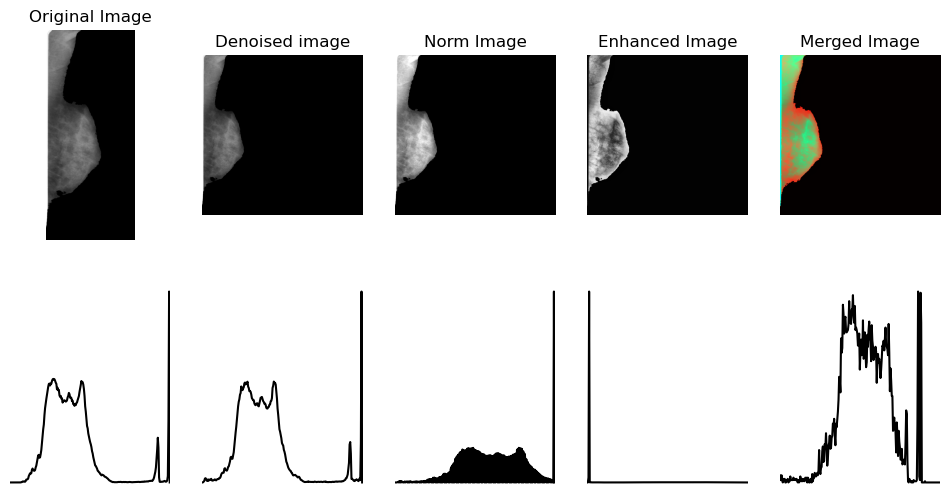

Path: DATABASE - DDSM/Normal/4508/D_4508_1.RIGHT_MLO.jpg, Label: 0, Type: 0


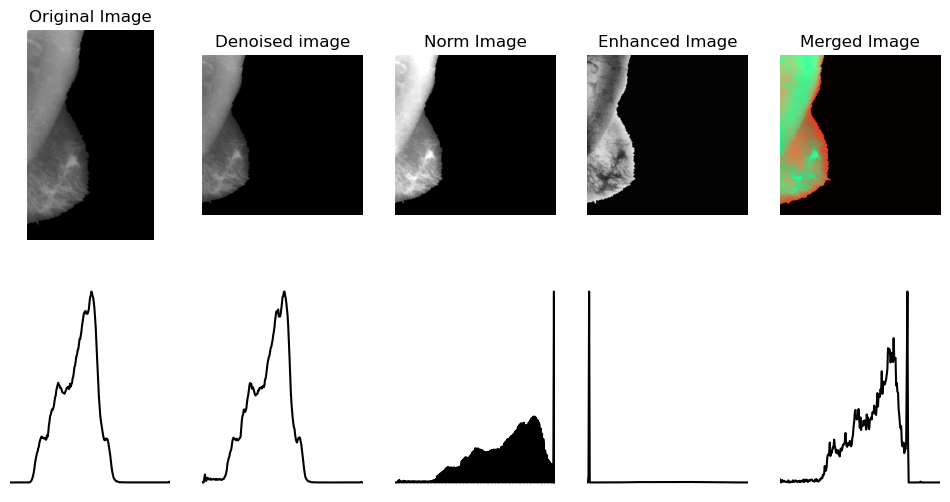

Path: DATABASE - DDSM/Cancer/3058/B_3058_1.LEFT_MLO.jpg, Label: 2, Type: Speculated


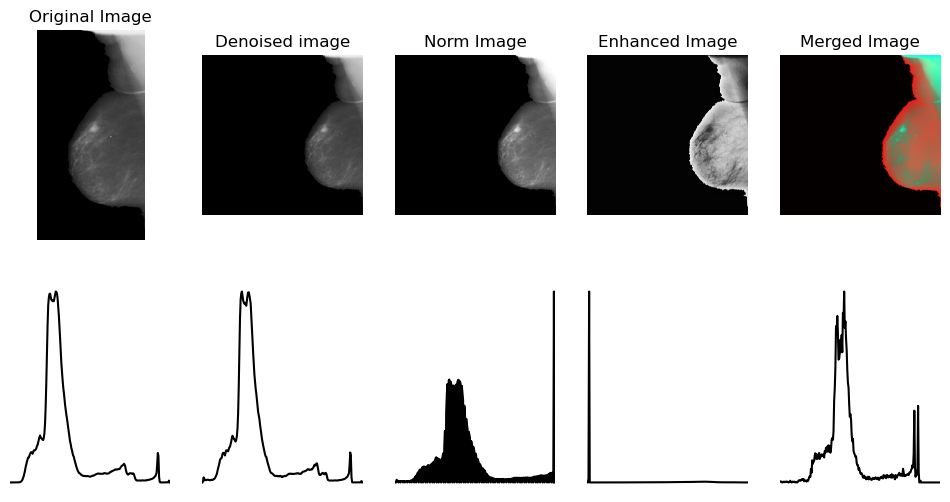

Path: DATABASE - DDSM/Benign/1778/A_1778_1.LEFT_MLO.jpg, Label: 1, Type: Circumscribed


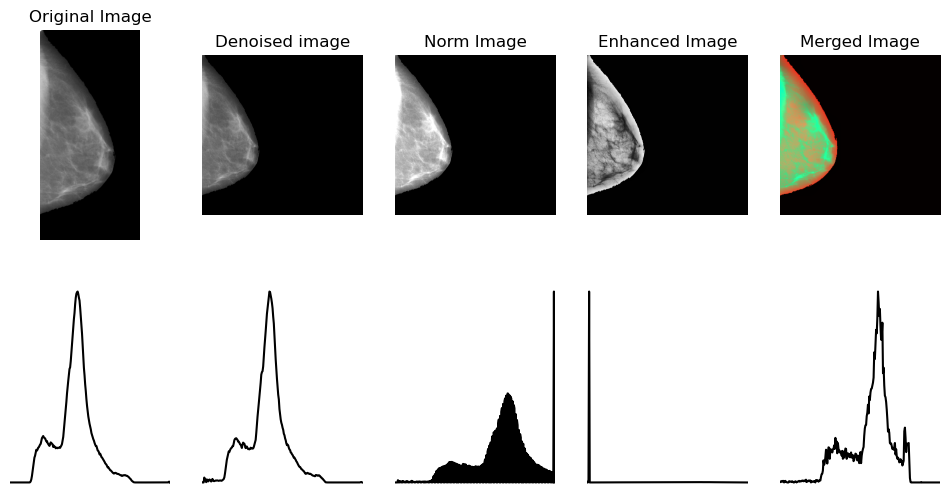

Path: DATABASE - DDSM/Normal/0109/A_0109_1.RIGHT_CC.jpg, Label: 0, Type: 0


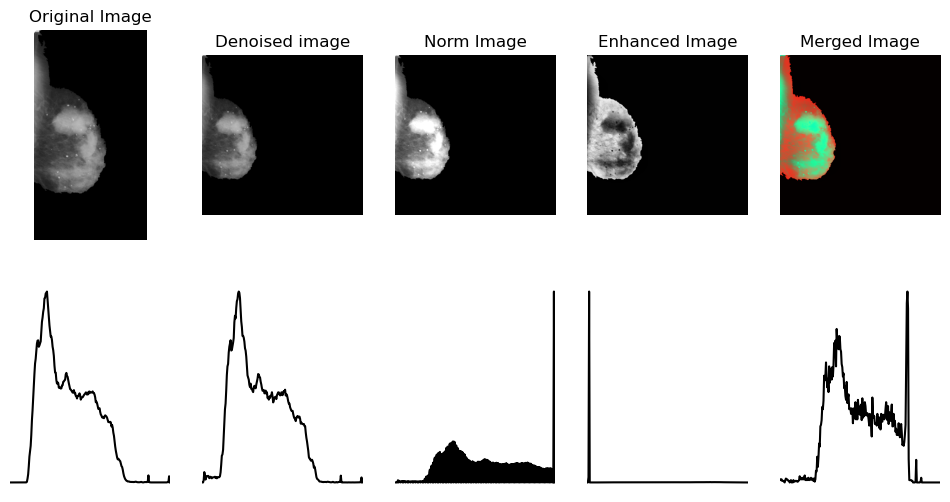

Path: DATABASE - DDSM/Cancer/0145/C_0145_1.LEFT_MLO.jpg, Label: 2, Type: Circumscribed


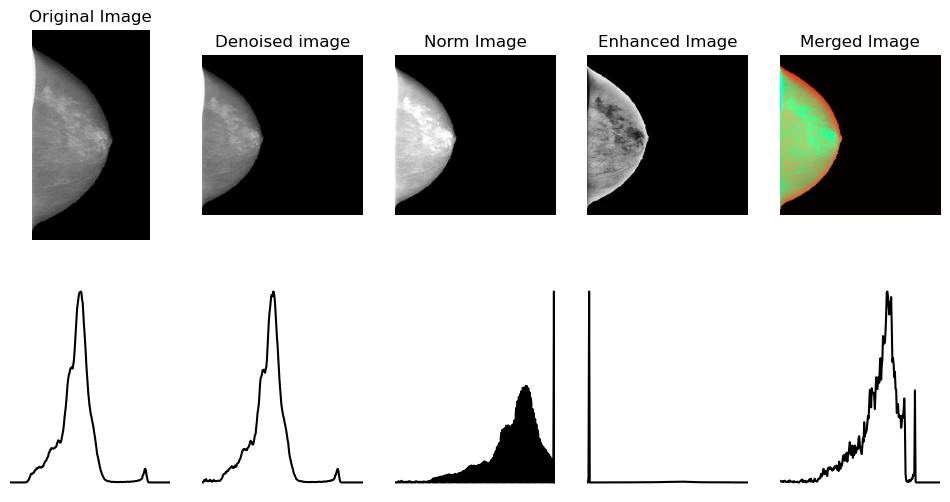

Path: DATABASE - DDSM/Cancer/0018/C_0018_1.LEFT_CC.jpg, Label: 2, Type: Lobulated


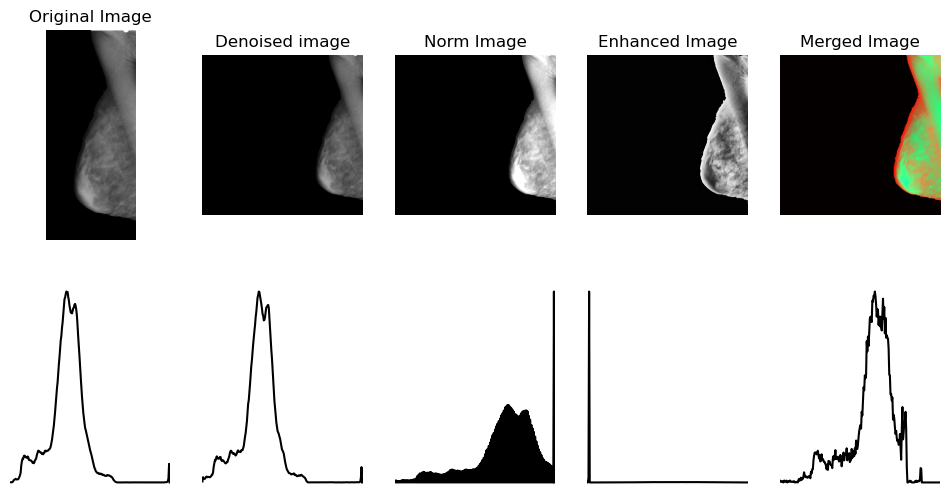

Path: DATABASE - DDSM/Normal/0584/A_0584_1.LEFT_MLO.jpg, Label: 0, Type: 0


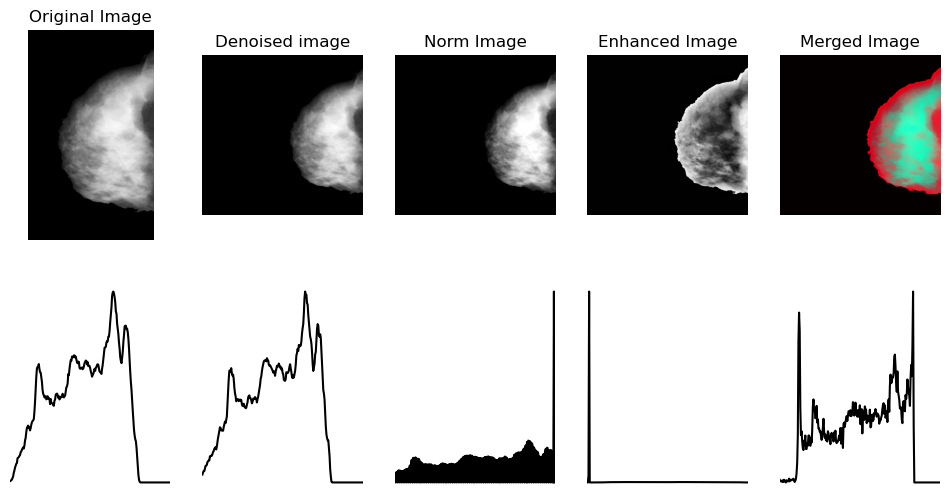

Path: DATABASE - DDSM/Normal/0266/A_0266_1.LEFT_CC.jpg, Label: 0, Type: 0


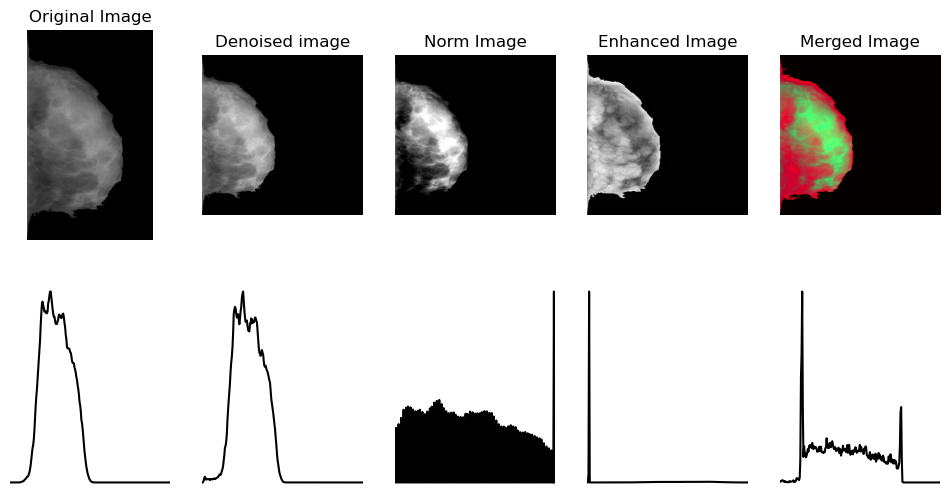

Path: DATABASE - DDSM/Normal/0390/A_0390_1.RIGHT_CC.jpg, Label: 0, Type: 0


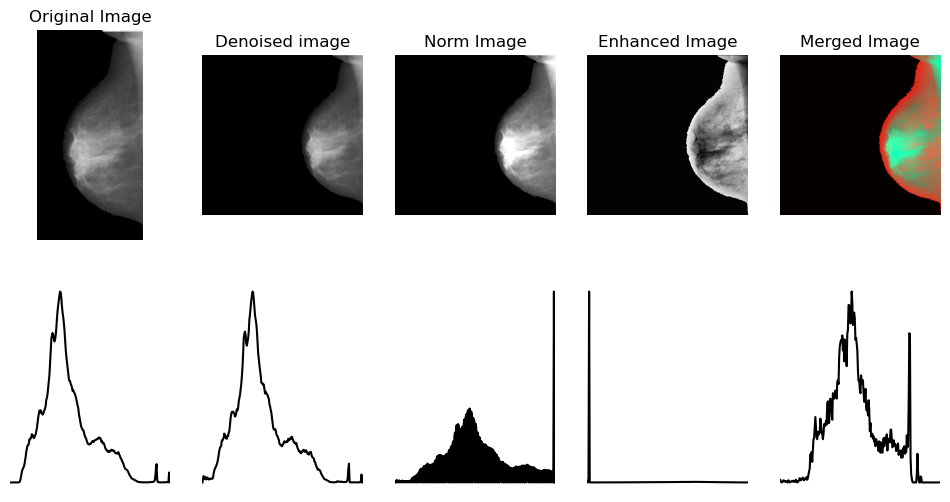

Path: DATABASE - DDSM/Normal/0440/A_0440_1.LEFT_MLO.jpg, Label: 0, Type: 0


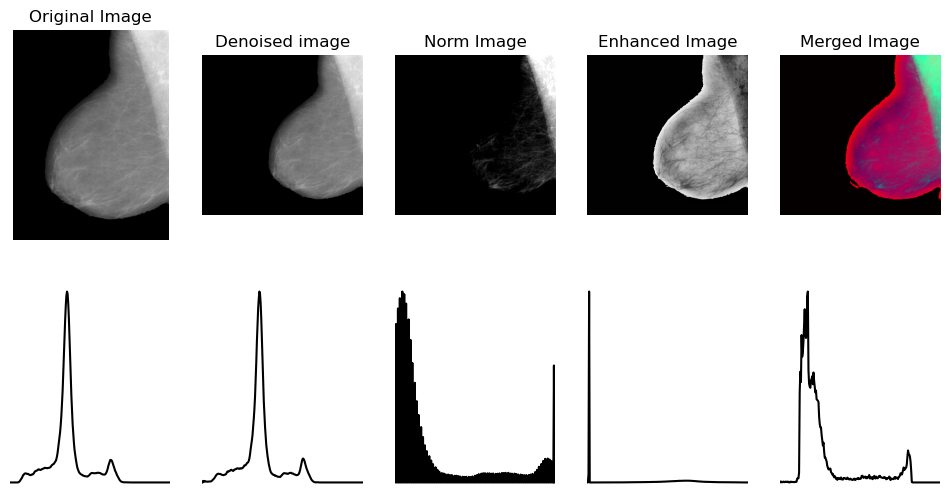

Path: DATABASE - DDSM/Normal/4529/D_4529_1.LEFT_MLO.jpg, Label: 0, Type: 0


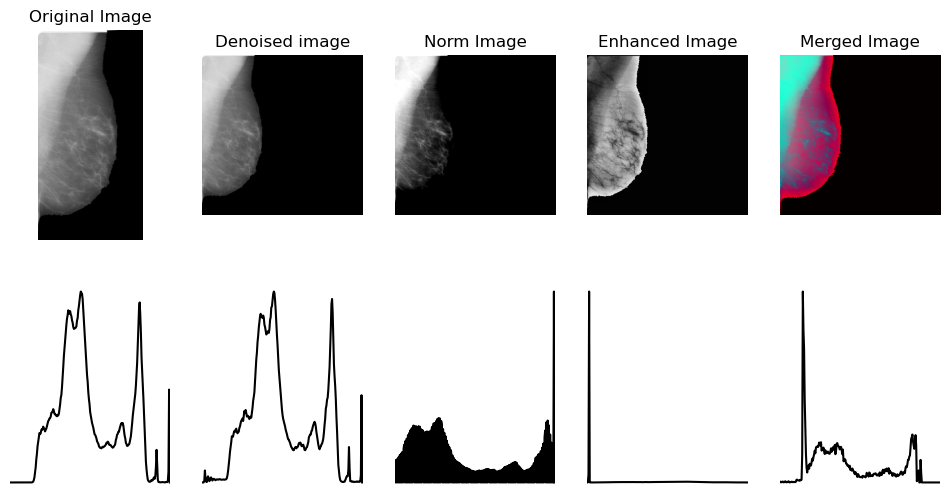

Path: DATABASE - DDSM/Normal/0391/A_0391_1.RIGHT_MLO.jpg, Label: 0, Type: 0


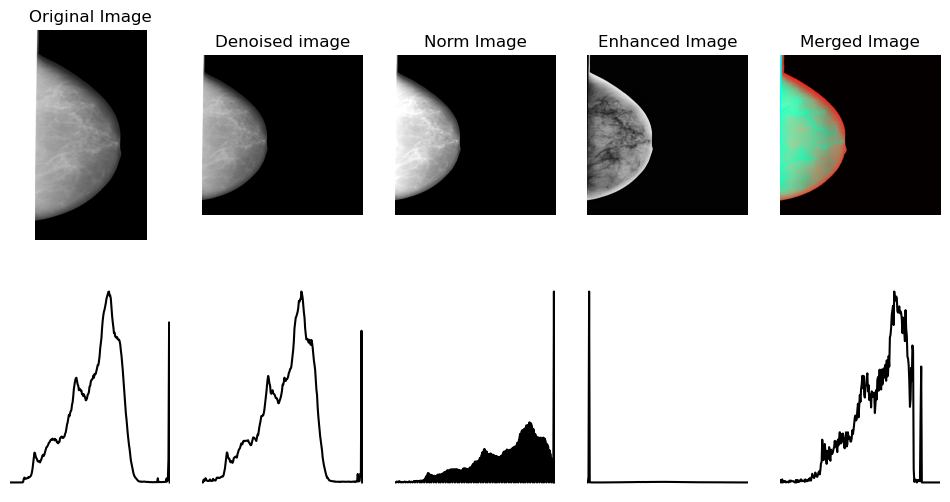

Path: DATABASE - DDSM/Normal/0076/A_0076_1.RIGHT_CC.jpg, Label: 0, Type: 0


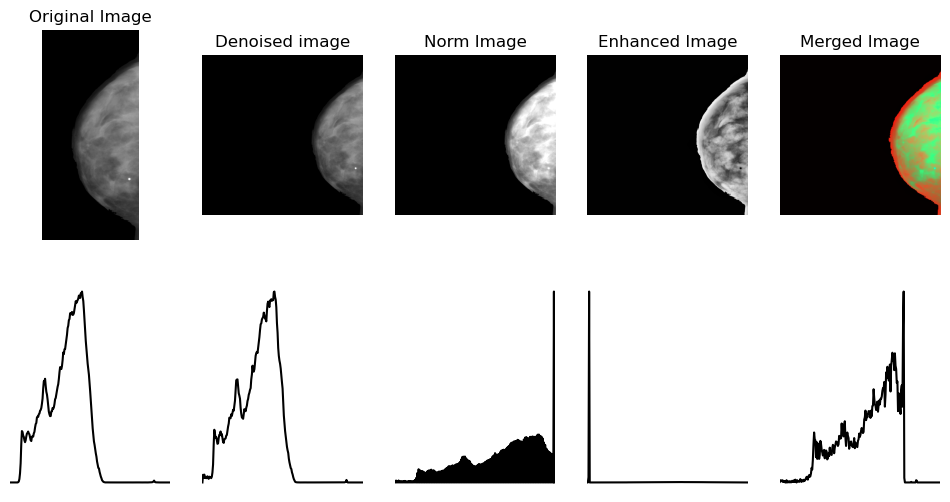

Path: DATABASE - DDSM/Normal/0318/A_0318_1.LEFT_CC.jpg, Label: 0, Type: 0


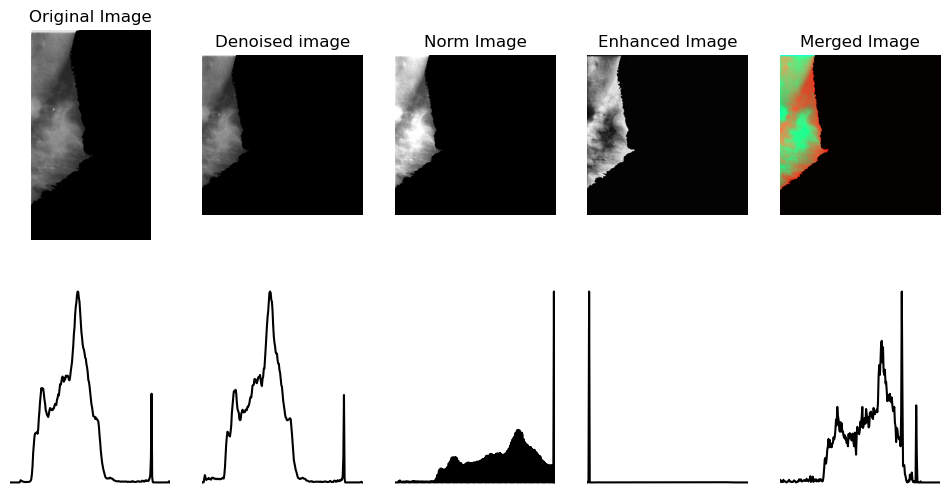

Path: DATABASE - DDSM/Cancer/0107/C_0107_1.LEFT_MLO.jpg, Label: 2, Type: Indistinct


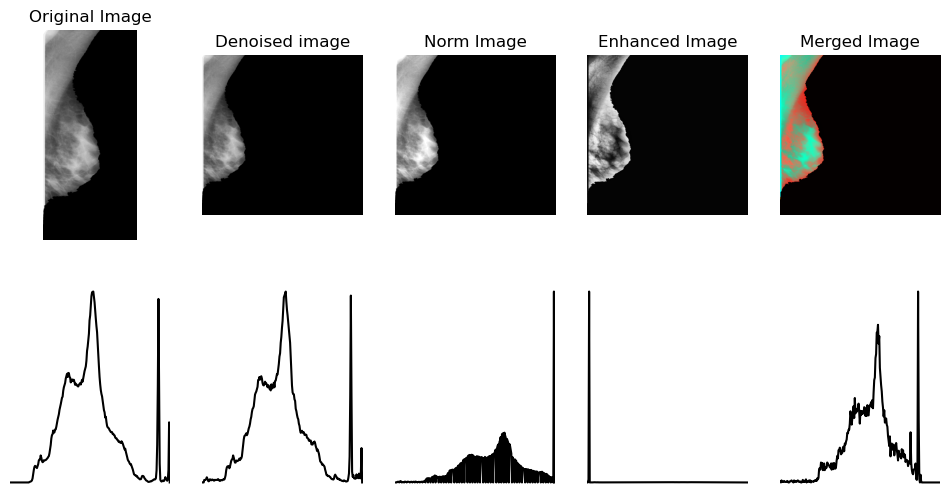

Path: DATABASE - DDSM/Normal/4517/D_4517_1.RIGHT_MLO.jpg, Label: 0, Type: 0


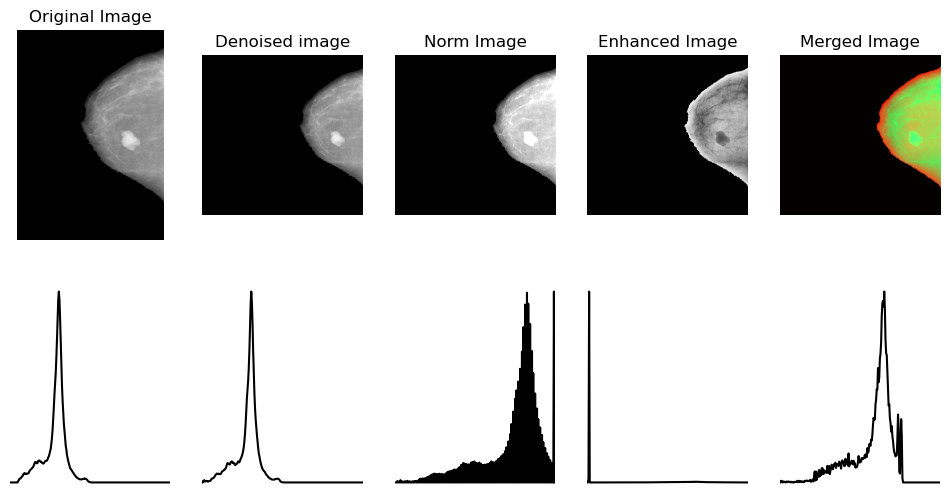

Path: DATABASE - DDSM/Benign/0305/C_0305_1.RIGHT_CC.jpg, Label: 1, Type: Circumscribed


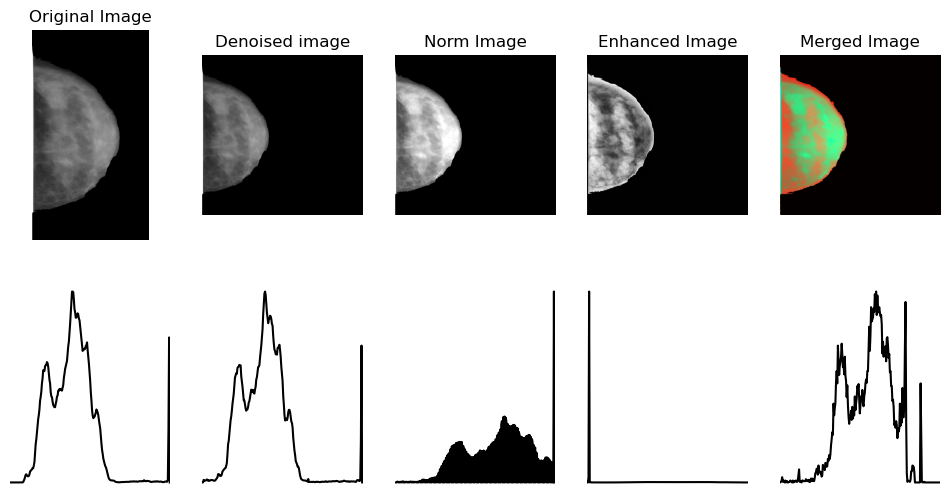

Path: DATABASE - DDSM/Normal/4585/D_4585_1.RIGHT_CC.jpg, Label: 0, Type: 0


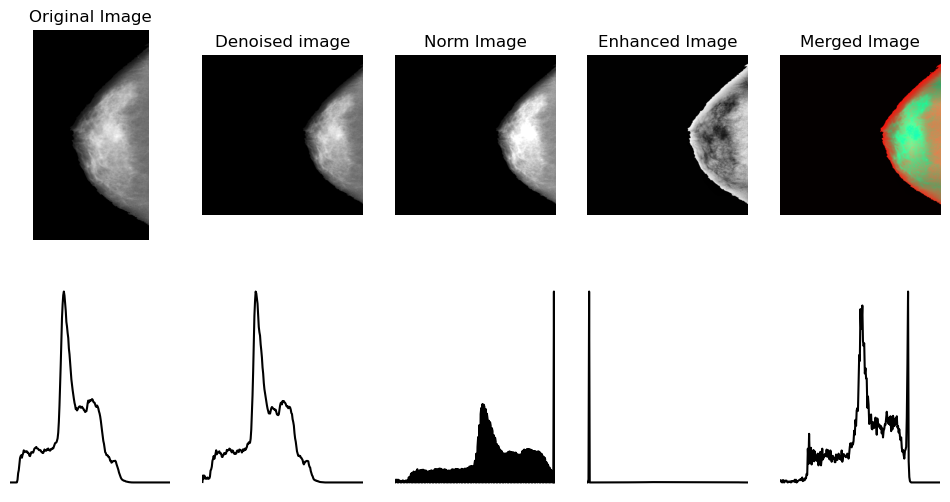

Path: DATABASE - DDSM/Benign/3142/B_3142_1.RIGHT_CC.jpg, Label: 1, Type: Circumscribed


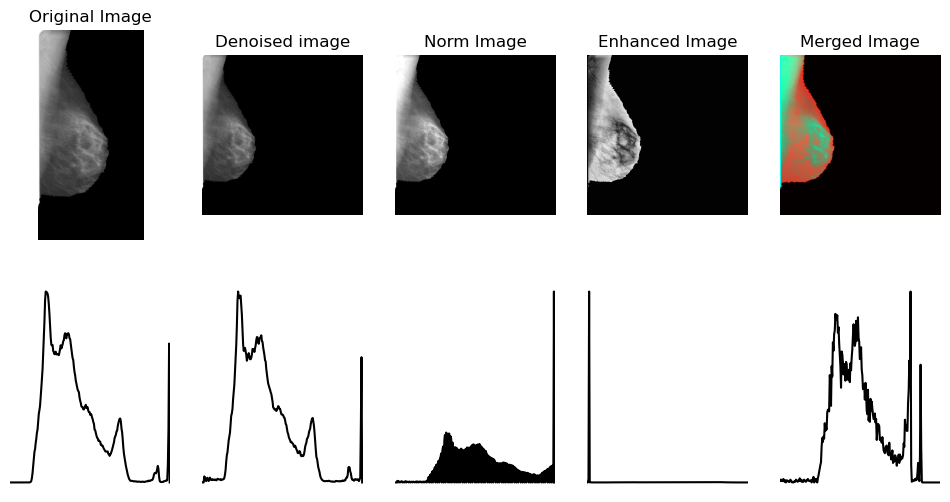

Path: DATABASE - DDSM/Normal/4527/D_4527_1.RIGHT_MLO.jpg, Label: 0, Type: 0


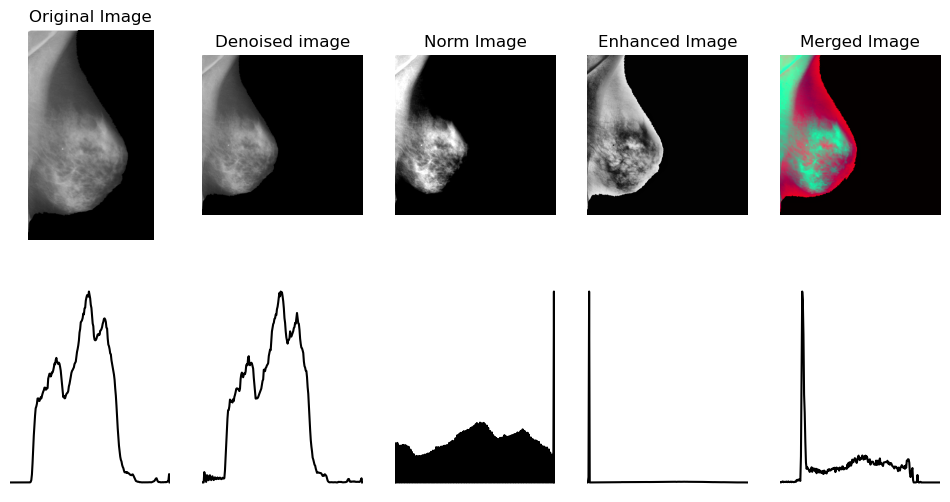

Path: DATABASE - DDSM/Normal/0220/A_0220_1.RIGHT_MLO.jpg, Label: 0, Type: 0


In [19]:
visualize_images(df, 'DDSM', num_samples=30, threshold_value = 30, seed=None)


## Preprocessem les imatges

## Balancegem el dataset

In [20]:
from imblearn.under_sampling import RandomUnderSampler

def balance_dataset(dataset, target_column='Label', random_state=42):
    """
    Realitza un submostreig aleatori per balancejar les classes d'un conjunt de dades.

    Args:
    - dataset (DataFrame): Conjunt de dades a balancejar.
    - target_column (str): Nom de la columna que conté les etiquetes de les classes a balancejar. Per defecte és 'Label'.
    - random_state (int): Valor del seed per a la generació de nombres aleatoris. Per defecte és 42.

    Returns:
    - DataFrame: Conjunt de dades balancejat.
    """

    X = dataset.drop(target_column, axis=1)
    y = dataset[target_column]

    balanced_data, balanced_labels = RandomUnderSampler(random_state=random_state).fit_resample(X, y)

    balanced_df = pd.DataFrame(balanced_data, columns=X.columns)
    balanced_df[target_column] = balanced_labels

    return balanced_df


df_balanced = balance_dataset(df)


## Dividim el dataset en train-test-val

In [21]:
def split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=121):
    """
    Divideix un DataFrame en conjunts de dades de tren, validació i prova segons les proporcions especificades.
    
    Arguments:
    df: pandas.DataFrame
        El DataFrame que conté les dades.
    train_size: float, opcional (per defecte és 0.7)
        La proporció del conjunt de dades a utilitzar com a conjunt d'entrenament.
    val_size: float, opcional (per defecte és 0.15)
        La proporció del conjunt de dades a utilitzar com a conjunt de validació.
    test_size: float, opcional (per defecte és 0.15)
        La proporció del conjunt de dades a utilitzar com a conjunt de prova.
    random_state: int, opcional (per defecte és 42)
        El valor de la llavor per a la generació de nombres aleatoris.

    Returns:
    tuple
        Una tupla que conté tres DataFrames: (train_df, val_df, test_df).
    """
    df_shuffled = df.sample(frac=1, random_state=random_state)

    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=random_state, stratify=df['Label'])
    val_df, test_df = train_test_split(temp_df, test_size=test_size / (val_size + test_size), random_state=random_state, stratify=temp_df['Label'])

    return train_df, val_df, test_df

train_df, val_df, test_df = split_dataset(df_balanced)


In [22]:
train_df.to_csv('train.csv', index=False) 
val_df.to_csv('val.csv', index=False) 
test_df.to_csv('test.csv', index=False) 

## Preprocessem les imatges i creem un array de numpy per cada conjunt d'entrenament, validació i prova

In [35]:
test_images, test_labels= preprocess(test_df, 224)

In [36]:
val_images, val_labels = preprocess(val_df, 224)

In [37]:
train_images, train_labels = preprocess(train_df, 224)

In [38]:
val_images.shape

(792, 380, 380, 3)

In [39]:
np.save('test_images.npy', test_images)
np.save('test_labels.npy', test_labels)
np.save('val_images.npy', val_images)
np.save('val_labels.npy', val_labels)
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)

## Comprovem que els resultats siguin els esperats

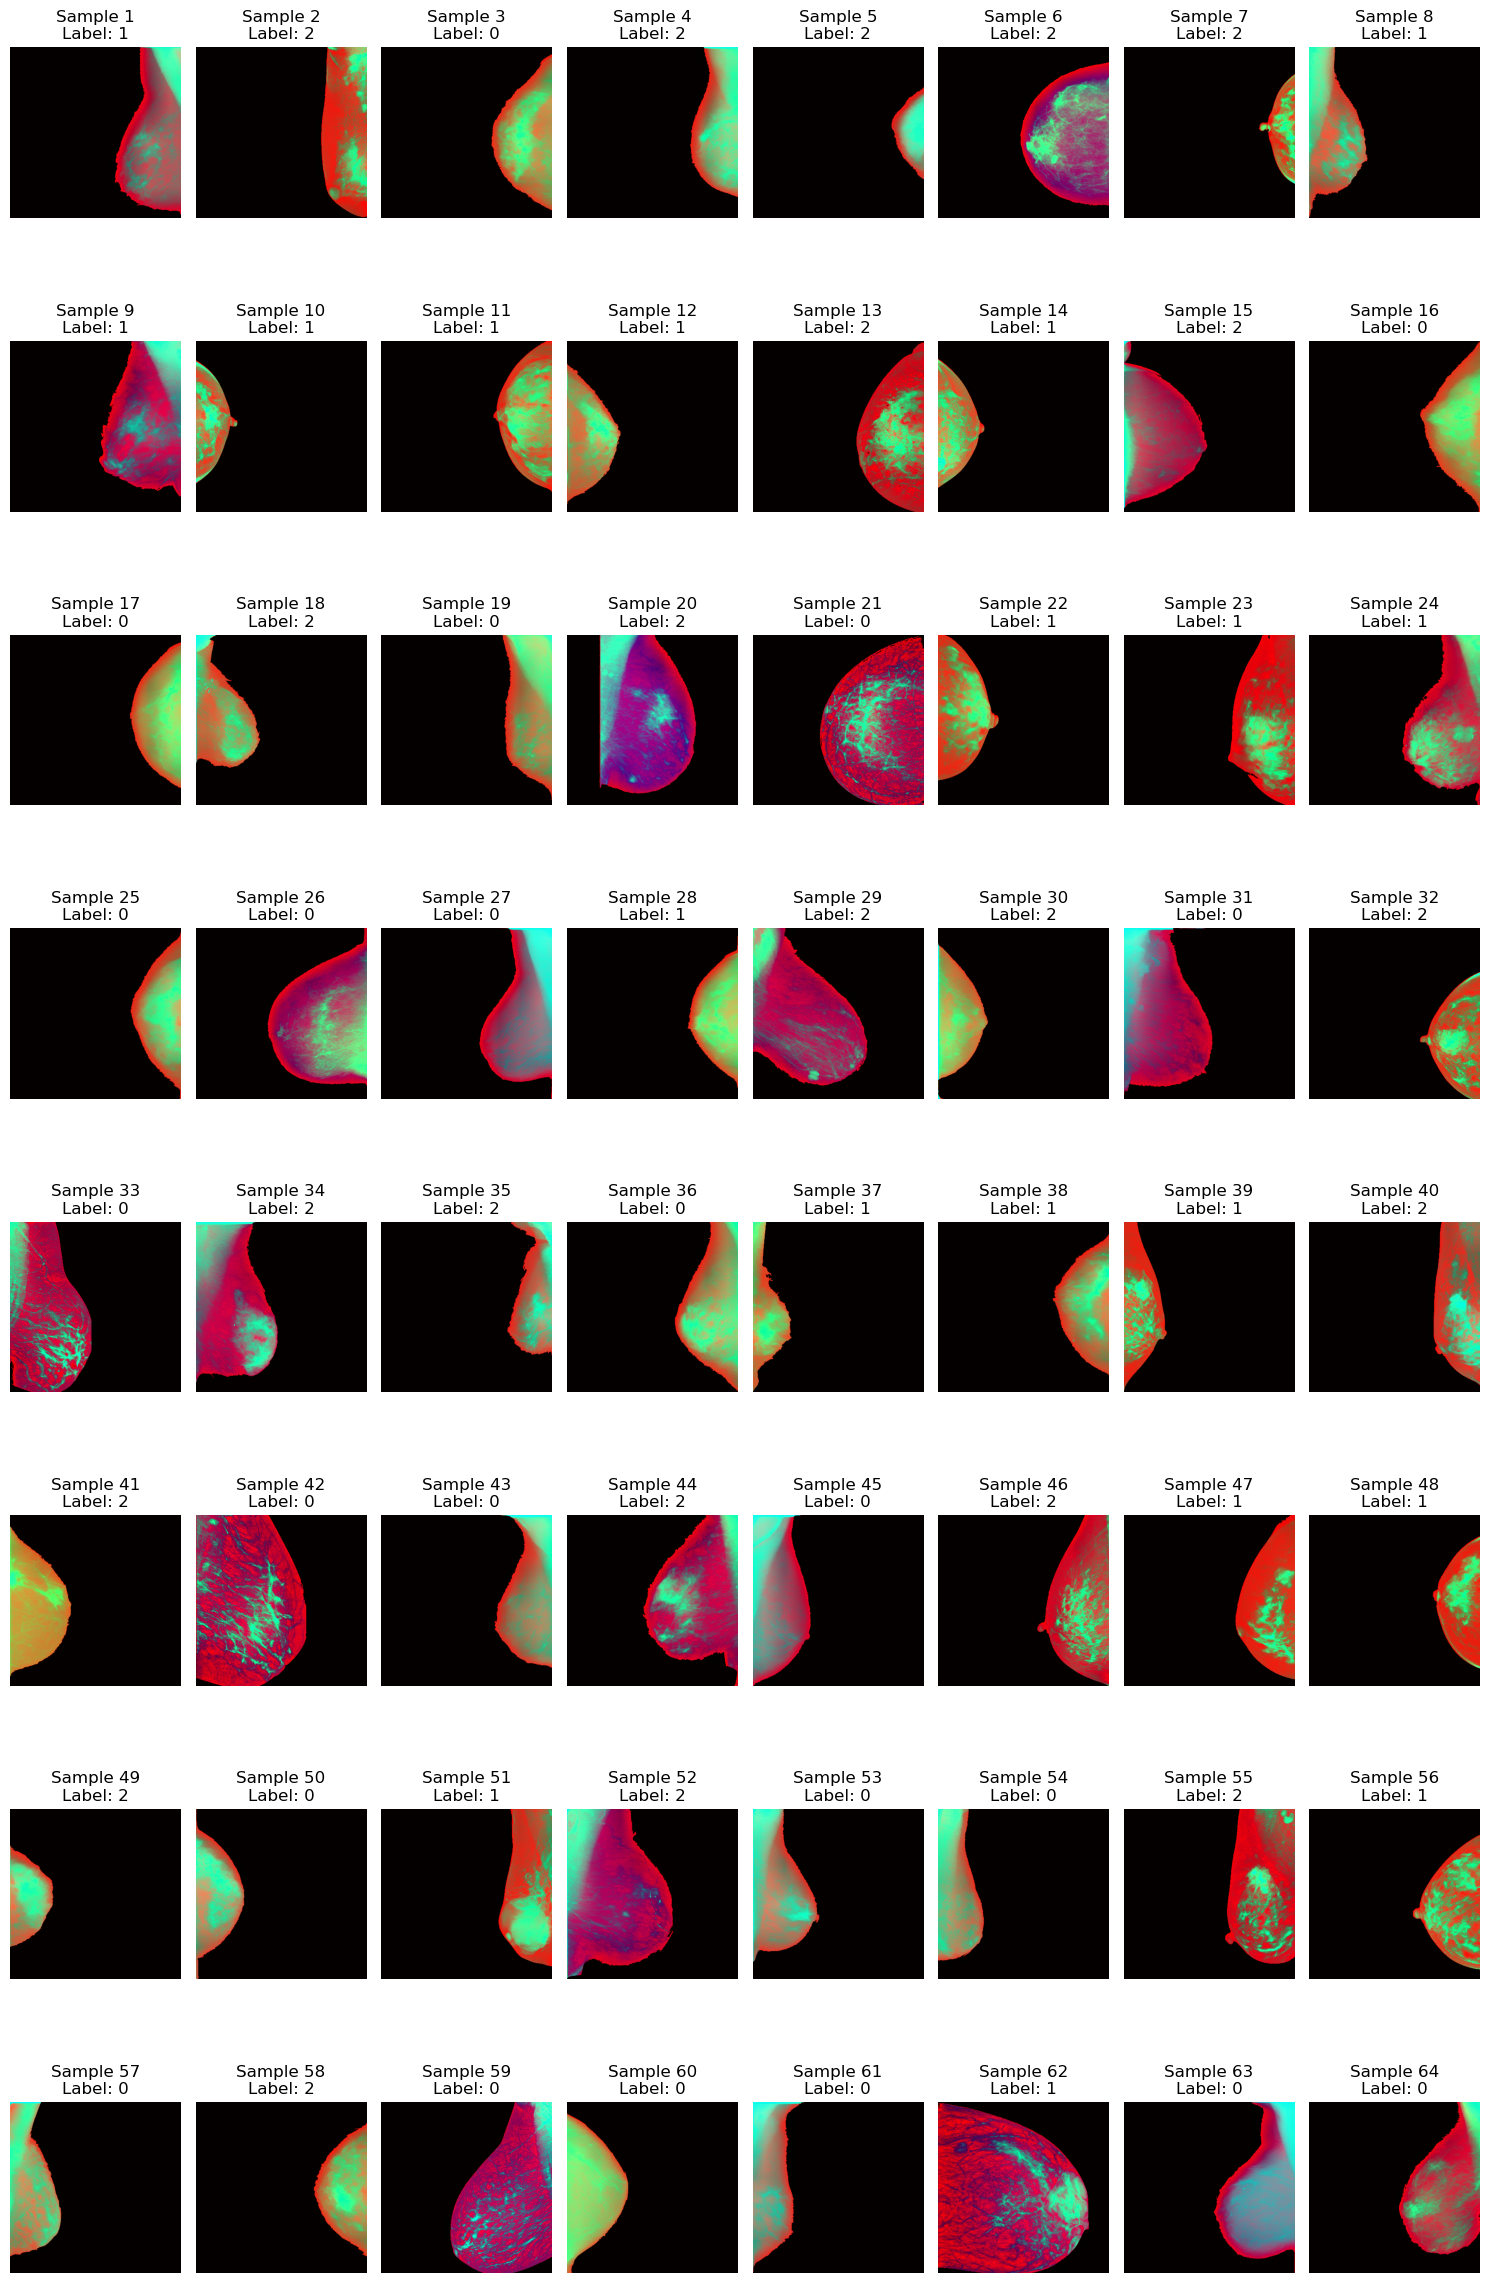

In [40]:
plot_examples_post(test_images, test_labels, 64)